In [1]:
import sklearn
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('bright')

In [2]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table



In [3]:
df=pd.read_csv('train.csv',index_col='Id')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
print(df.describe())

        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ..

In [6]:
mzvt=missing_zero_values_table(df)


Your selected dataframe has 80 columns and 1460 Rows.
There are 19 columns that have missing values.


The table above shows features: PoolQC, MiscFeature, Alley, Fence, FireplaceQu and LotFrontage having significantly more missing values than the majority of the features. I am going to drop these features.

In [7]:
#Creating a slice of the % of total value column
drop_mzvt=mzvt['% of Total Values'] 
#Creating a list of index names which have more than 10% missing values
todrop=drop_mzvt[drop_mzvt>10].index
#Dropping the list of index names from the df
df.drop(todrop,axis=1,inplace=True)

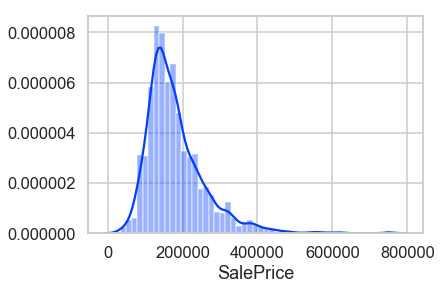

In [8]:
sns.distplot(df['SalePrice'])